In [1]:
import torch # for automatic gradient calcluations
import torchvision # for some transformations

from medmnist import BloodMNIST # dataset for analysis

import matplotlib.pyplot as plt # visualization
%matplotlib notebook

# Start by loading the BloodMNIST dataset

We will convert the RGB images to grayscale, and convert them to torch Tensors for later analysis.

## Load the training dataset

In [2]:
dataset = BloodMNIST(split='train',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [3]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=8,num_workers=8)

## Load the testing dataset

In [4]:
dataset_test = BloodMNIST(split='test',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)
dataloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=8,num_workers=8)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


## Load the validation dataset

In [5]:
dataset_val = BloodMNIST(split='val',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=8,num_workers=8)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


# Train our first model

We will predict the class by minimizing sum of square error in the integer label.



## Define the model

Our classifier will have 4 convolution layers.

The first layer will map from 1 channel (grayscale) to 8 feature maps.

The subsequent layers will downsample by a factor of 2 (strided convolution).

The output will be only one channel.

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        channels0 = 8
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c3 = torch.nn.Conv2d(channels0*4,1,kernel_size,stride, padding)
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c3(x)
        
        
        # average pool so we get one number        
        x = torch.mean(x,(-1,-2))
        
        return x

## move it to our desired device

In [7]:
device = 'cuda:0' # change to 'cpu' if you don't have a gpu that will work with torch
device = 'cpu'

In [8]:
model = Model()
model = model.to(device)

## count the number of parameters

In [9]:
nparam = 0
for p in model.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

6177 parameters


## set up our optimizer

In [10]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

## train the model 

<IPython.core.display.Javascript object>


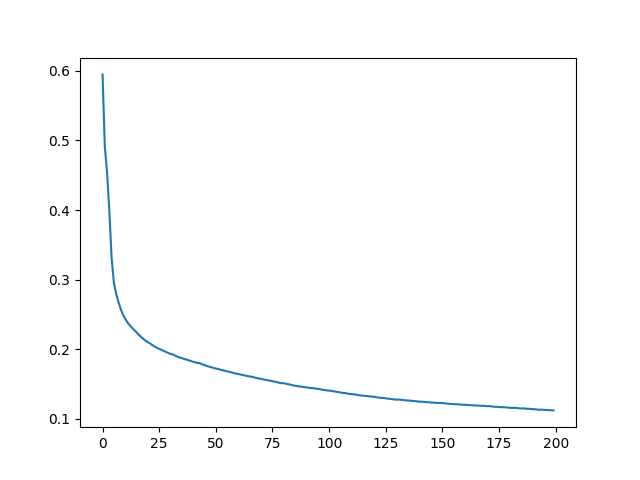

In [11]:
nepochs = 200
Esave = []
model = model.to(device)
for e in range(nepochs):
     
        
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model(x)
        
        # loss
        E = torch.mean((out-l)**2)
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [12]:
# save the model to disk
#torch.save(model.state_dict(),'sse_model.pt')

In [13]:
# load the model from disk
model.load_state_dict(torch.load('sse_model.pt'))

<All keys matched successfully>

## compute the accuracy

In [14]:
# accuracy on training set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model(x)
        c = torch.round(out)
        c[c<0] = 0
        c[c>7] = 7
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l).item()
accuracytrain = correct/count
print(f'accuracy train is {accuracytrain}')


accuracy train is 0.4557237227192909


In [15]:
# accuracy on validation set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model(x)
        c = torch.round(out)
        c[c<0] = 0
        c[c>7] = 7
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l).item()
accuracyval = correct/count
print(f'accuracy val is {accuracyval}')

accuracy val is 0.38843457943925236


In [16]:
# accuracy on test set
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model(x)
        c = torch.round(out)
        c[c<0] = 0
        c[c>7] = 7

        
        
        count += x.shape[0]
        correct += torch.sum(c==l).item()
accuracy = correct/count
print(f'accuracy is {accuracy}')


accuracy is 0.40836012861736337


## build a confusion matrix

<IPython.core.display.Javascript object>


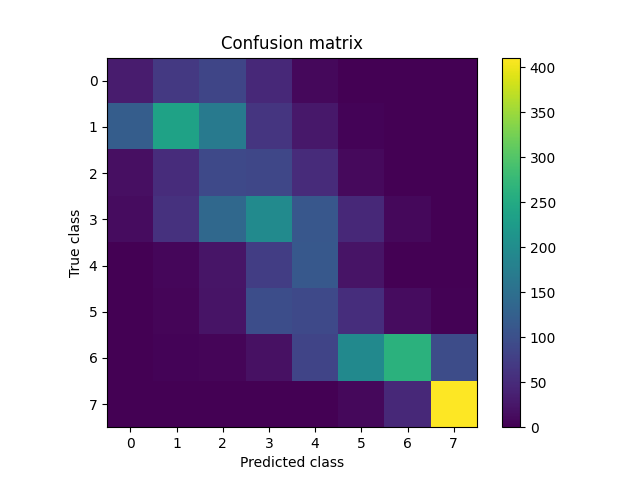

<IPython.core.display.Javascript object>


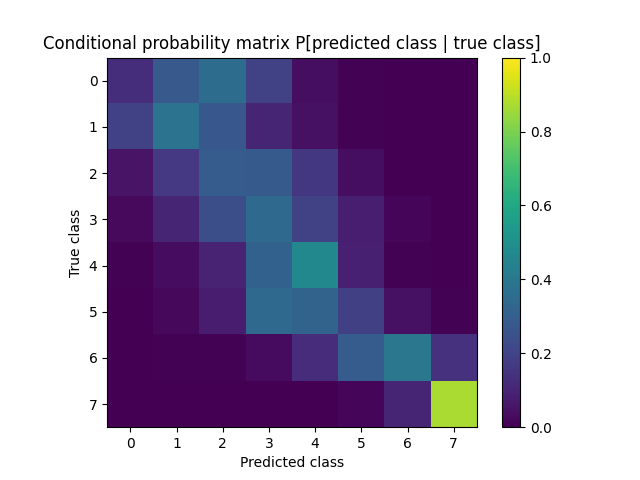

<IPython.core.display.Javascript object>


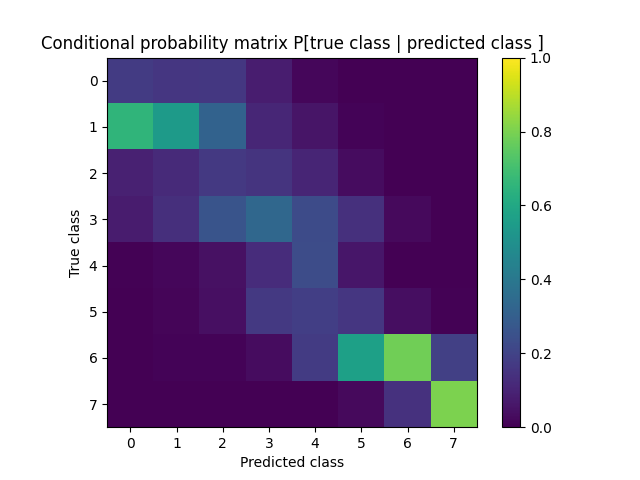

Text(0.5, 0, 'Predicted class')

In [17]:
# confusion
confusion = torch.zeros((8,8))
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model(x)
        c = torch.round(out)
        c[c<0] = 0
        c[c>7] = 7

        
        # find the true answer, and our output, and increment this element of the matrix
        count += x.shape[0]
        correct += torch.sum(c==l).item()
        for i in range(c.shape[0]):
            confusion[l[i].int().item(),c[i].int().item()] += 1

# show the confusion matrix
fig,ax = plt.subplots()
handle = ax.imshow(confusion)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')
fig.colorbar(handle)
ax.set_title('Confusion matrix')

# normalize it over the the predicted classes
conditional = confusion / torch.sum(confusion,-1,keepdims=True)
fig,ax = plt.subplots()
handle = ax.imshow(conditional,vmin=0,vmax=1)
ax.set_title('Conditional probability matrix P[predicted class | true class]')
fig.colorbar(handle)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

# normalized it over the true class
conditional2 = confusion / torch.sum(confusion,-2,keepdims=True)
fig,ax = plt.subplots()
handle = ax.imshow(conditional2,vmin=0,vmax=1)
ax.set_title('Conditional probability matrix P[true class | predicted class ]')
fig.colorbar(handle)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

# Modify the model so it can use cross entropy loss

In [18]:
class Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        channels0 = 8
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c3 = torch.nn.Conv2d(channels0*4,8,kernel_size,stride, padding) # note 8 not 1, this is the only change
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c3(x)
        
        
        # average pool so we get one pmf        
        x = torch.mean(x,(-1,-2))
        
        return x

In [19]:
model1 = Model1()
model1 = model1.to(device)

In [20]:
nparam = 0
for p in model1.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

8200 parameters


In [21]:
optimizer = torch.optim.Adam(model1.parameters(),lr=1e-3)

<IPython.core.display.Javascript object>


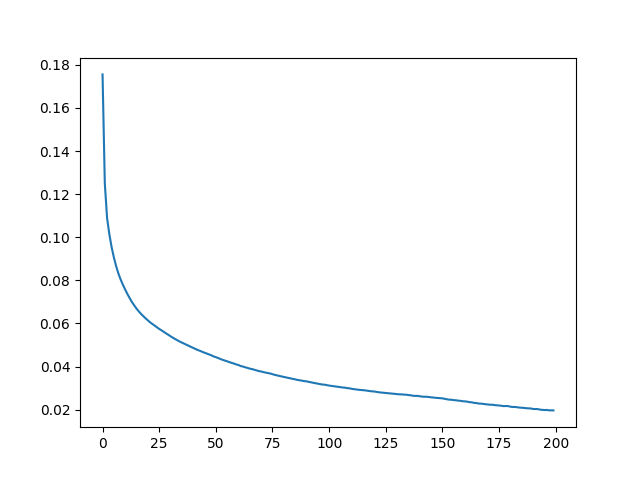

In [22]:
nepochs = 200
Esave = []
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
    
   
        
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model1(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [23]:
# save the model to disk
#torch.save(model1.state_dict(),'model1.pt')

In [24]:
# load the model from disk
model1.load_state_dict(torch.load('model1.pt'))

<All keys matched successfully>

In [25]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy1train = correct/count
print(f'accuracy train is {accuracy1train}')

accuracy train is 0.8834350698218915


In [26]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy1val = correct/count
print(f'accuracy val is {accuracy1val}')

accuracy val is 0.8171728971962616


In [27]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy1 = correct/count
print(f'accuracy is {accuracy1}')



accuracy is 0.8193510669394913


<IPython.core.display.Javascript object>


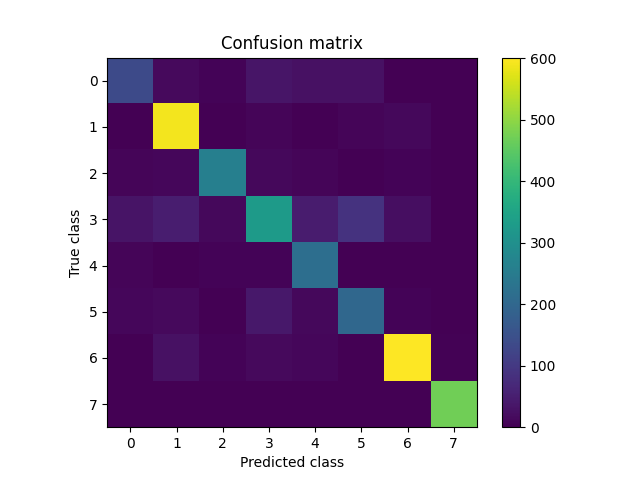

<IPython.core.display.Javascript object>


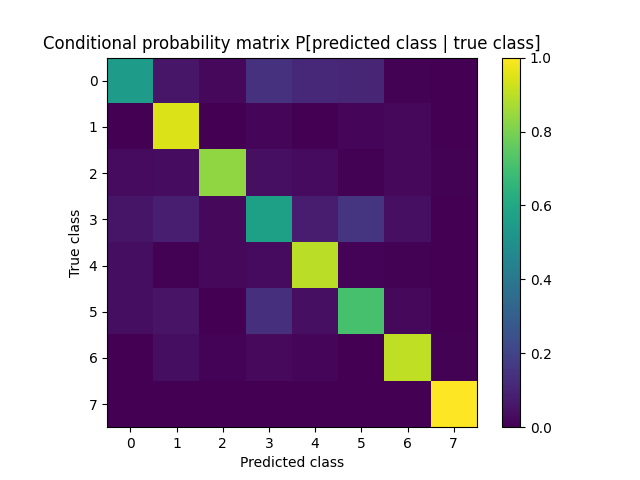

<IPython.core.display.Javascript object>


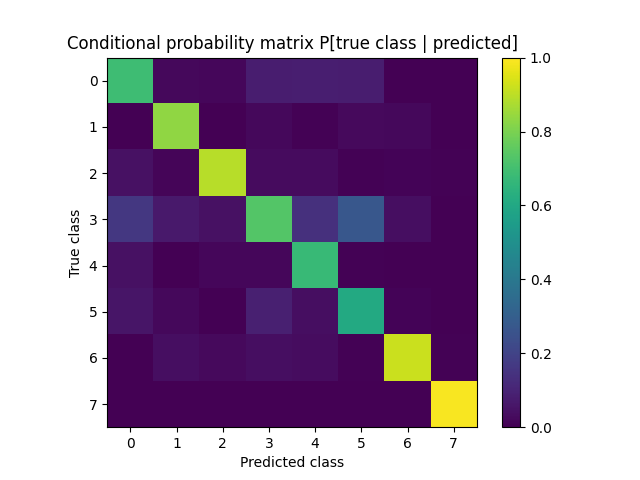

Text(0.5, 0, 'Predicted class')

In [28]:
# confusion
confusion = torch.zeros((8,8))
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1)

        
        
        count += x.shape[0]
        correct += torch.sum(c==l).item()
        for i in range(c.shape[0]):        
            confusion[l[i].int().item(),c[i].int().item()] += 1
                
fig,ax = plt.subplots()
handle = ax.imshow(confusion)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')
fig.colorbar(handle)
ax.set_title('Confusion matrix')

conditional = confusion / torch.sum(confusion,-1,keepdims=True)
fig,ax = plt.subplots()
handle = ax.imshow(conditional,vmin=0,vmax=1)
ax.set_title('Conditional probability matrix P[predicted class | true class]')
fig.colorbar(handle)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')


conditional2 = confusion / torch.sum(confusion,-2,keepdims=True)
fig,ax = plt.subplots()
handle = ax.imshow(conditional2,vmin=0,vmax=1)
ax.set_title('Conditional probability matrix P[true class | predicted]')
fig.colorbar(handle)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

<IPython.core.display.Javascript object>


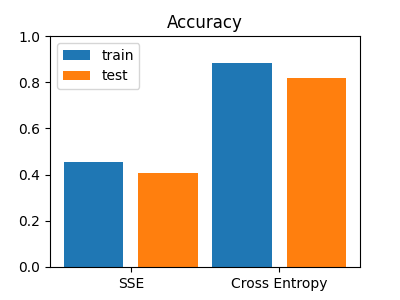

In [29]:
fig,ax = plt.subplots(figsize=(4,3))
ax.bar([-0.25,0.75],[accuracytrain,accuracy1train],width=0.4,label='train')
ax.bar([0.25,1.25],[accuracy,accuracy1],width=0.4,label='test')
ax.set_xticks((0,1))
ax.set_xticklabels(['SSE','Cross Entropy'])
ax.set_ylim([0,1])
#ax.text(0,0.38,'38%',horizontalalignment='center')
#ax.text(1,0.82,'82%',horizontalalignment='center')
ax.set_title('Accuracy')
ax.legend()

# Now let's build a deeper model

In [30]:
class Model2(torch.nn.Module):
    ''' Model 2 is the deep model'''
    def __init__(self):
        super().__init__()
        
        # reduce the number of channels from 8 to 4
        channels0 = 4
        kernel_size = 3
        stride = 2
        padding = 1
        
        # but double the number of convolution layers
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        self.c0a = torch.nn.Conv2d(channels0,channels0,kernel_size,1, padding)
        
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c1a = torch.nn.Conv2d(channels0*2,channels0*2,kernel_size,1, padding)
        
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c2a = torch.nn.Conv2d(channels0*4,channels0*4,kernel_size,1, padding)
        
        self.c3 = torch.nn.Conv2d(channels0*4,channels0*8,kernel_size,stride, padding) 
        self.c3a = torch.nn.Conv2d(channels0*8,8,kernel_size,1, padding) # note 8 not 1
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c0a(x)
        x = torch.relu(x)                
        
        
        x = self.c1(x)
        x = torch.relu(x)
                
        x = self.c1a(x)
        x = torch.relu(x)
        
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c2a(x)
        x = torch.relu(x)
        
        
        x = self.c3(x)
        x = torch.relu(x)
        
        # no nonliearity the last time
        x = self.c3a(x)
        
        
        # average pool so we get one pmf   
        x = torch.mean(x,(-1,-2))
        
        return x

In [31]:
model2 = Model2()
model2 = model2.to(device)

In [32]:
nparam = 0
for p in model2.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

11508 parameters


In [33]:
optimizer = torch.optim.Adam(model2.parameters(),lr=1e-3)

<IPython.core.display.Javascript object>


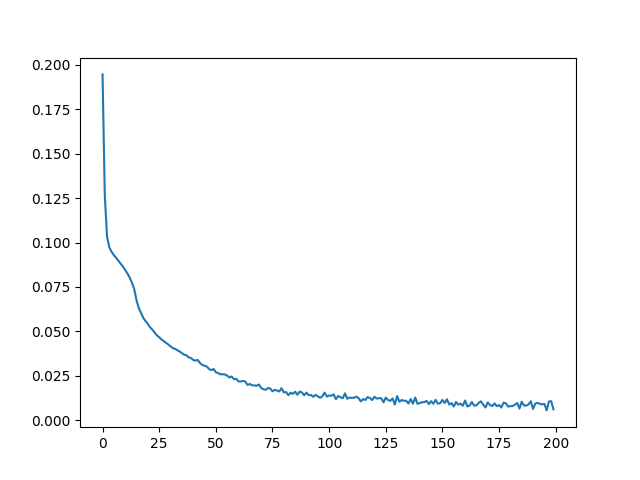

In [34]:
nepochs = 200
Esave = []
model2 = model2.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
    
 
        
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model2(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [35]:
# save the model to disk
#torch.save(model2.state_dict(),'model2.pt')

In [36]:
# load the model from disk
model2.load_state_dict(torch.load('model2.pt'))

<All keys matched successfully>

In [37]:


with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy2train = correct/count
print(f'accuracy trainis {accuracy2train}')

accuracy trainis 0.9352788694706915


In [38]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy2val = correct/count
print(f'accuracy val is {accuracy2val}')

accuracy val is 0.8230140186915887


In [39]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model2(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy2 = correct/count
print(f'accuracy is {accuracy2}')


accuracy is 0.825781935106694


# Build a wide model

In [40]:
class Model3(torch.nn.Module):
    ''' Model 3 is the wide model'''
    def __init__(self):
        super().__init__()
        
        channels0 = 9 # note we put more channels here at the beginning
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c3 = torch.nn.Conv2d(channels0*4,8,kernel_size,stride, padding) # note 8 not 1
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c3(x)
        
        
        # average pool so we get one number
        
        x = torch.mean(x,(-1,-2))
        
        return x

In [41]:
model3 = Model3()
model3 = model3.to(device)

In [42]:
# check the parameters, note it is about the same as the deep model
nparam = 0
for p in model3.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

10034 parameters


In [43]:
optimizer = torch.optim.Adam(model3.parameters(),lr=1e-3)

<IPython.core.display.Javascript object>


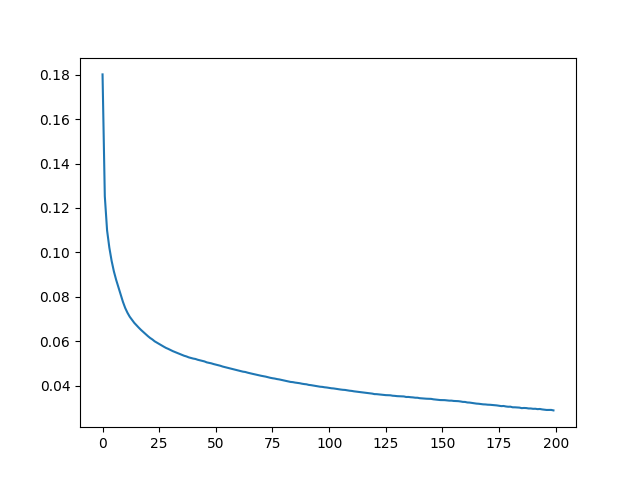

In [44]:
nepochs = 200
Esave = []
model3 = model3.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):                 
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model3(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [45]:
# save the model to disk
#torch.save(model3.state_dict(),'model3.pt')

In [46]:
# load the model from disk
model3.load_state_dict(torch.load('model3.pt'))

<All keys matched successfully>

In [47]:

with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model3(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy3train = correct/count
print(f'accuracy train is {accuracy3train}')



accuracy train is 0.896061543607325


In [48]:


with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model3(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy3val = correct/count
print(f'accuracy is {accuracy3val}')

accuracy is 0.842873831775701


In [49]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model3(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy3 = correct/count
print(f'accuracy is {accuracy3}')



accuracy is 0.8418591055247003


<IPython.core.display.Javascript object>


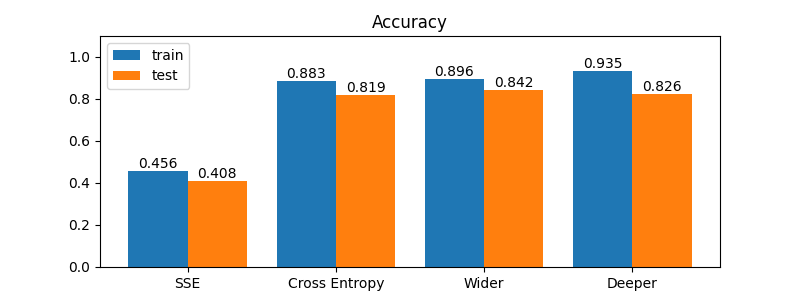

In [50]:
fig,ax = plt.subplots(figsize=(8,3))
h = ax.bar([-0.2,0.8,1.8,2.8],[accuracytrain,accuracy1train,accuracy3train,accuracy2train],width=0.4,label='train')
ax.bar_label(h,fmt='%0.3f')
h = ax.bar([0.2,1.2,2.2,3.2],[accuracy,accuracy1,accuracy3,accuracy2],width=0.4,label='test')
ax.bar_label(h,fmt='%0.3f')
ax.set_xticks((0,1,2,3))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper'])
ax.set_ylim([0,1])
ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()

# Add batch normalization, and residual connections

In [51]:
class Model4(torch.nn.Module):
    ''' Model 4 is the deep model with res and bn'''
    def __init__(self):
        super().__init__()
        
        channels0 = 4
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        # note a batch norm layer needs to know the number of channels in the image
        # for each channel, it will compute means and variances by averaging over all
        # minibatches, rows, and columns
        self.b0 = torch.nn.BatchNorm2d(channels0)
        self.c0a = torch.nn.Conv2d(channels0,channels0,kernel_size,1, padding)
        self.b0a = torch.nn.BatchNorm2d(channels0)
        
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.b1 = torch.nn.BatchNorm2d(channels0*2)
        self.c1a = torch.nn.Conv2d(channels0*2,channels0*2,kernel_size,1, padding)
        self.b1a = torch.nn.BatchNorm2d(channels0*2)
        
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.b2 = torch.nn.BatchNorm2d(channels0*4)
        self.c2a = torch.nn.Conv2d(channels0*4,channels0*4,kernel_size,1, padding)
        self.b2a = torch.nn.BatchNorm2d(channels0*4)
        
        self.c3 = torch.nn.Conv2d(channels0*4,channels0*8,kernel_size,stride, padding) 
        self.b3 = torch.nn.BatchNorm2d(channels0*8)
        self.c3a = torch.nn.Conv2d(channels0*8,8,kernel_size,1, padding) # note 8 not 1
    
    
    def forward(self,x):
        # convolutions and nonlinearities
        x0 = x.clone()
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)        
        x = torch.concatenate((x[:,:1]+x0,x[:,1:]),1)        
        
        x0 = x.clone()
        x = self.c0a(x)
        x = self.b0a(x)
        x = torch.relu(x)                
        x = x + x0
        
        
        x0 = x.clone()
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)        
        x = torch.concatenate( (x[:,:x.shape[1]//2]+x0[:,:,::2,::2], x[:,x.shape[1]//2:]),1)# half as many channels, twice the pixels
        
        
        x0 = x.clone()
        x = self.c1a(x)
        x = self.b1a(x)
        x = torch.relu(x)
        x = x + x0
        
        x0 = x.clone()
        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)
        x = torch.concatenate( (x[:,:x.shape[1]//2]+x0[:,:,::2,::2], x[:,x.shape[1]//2:]),1)# half as many channels, twice the pixels
        
        x0 = x.clone()
        x = self.c2a(x)
        x = self.b2a(x)
        x = torch.relu(x)
        x = x + x0
        
        x0 = x.clone()
        x = self.c3(x)
        x = self.b3(x)
        x = torch.relu(x)
        x = torch.concatenate( (x[:,:x.shape[1]//2]+x0[:,:,::2,::2], x[:,x.shape[1]//2:]),1)# half as many channels, twice the pixels
        
        
        x = self.c3a(x)
        
        
        # average pool so we get one number
        
        x = torch.mean(x,(-1,-2))
        
        return x

In [52]:
model4 = Model4()
model4 = model4.to(device)

In [53]:
optimizer = torch.optim.Adam(model4.parameters(),lr=1e-3)

In [54]:
nparam = 0
for p in model4.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

11684 parameters


<IPython.core.display.Javascript object>


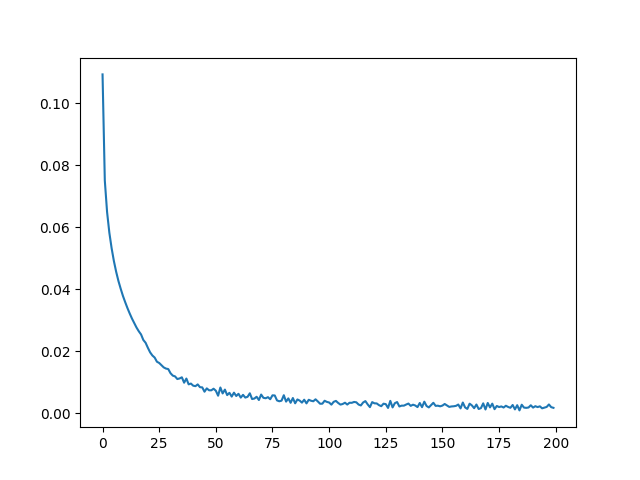

In [55]:
nepochs = 200
Esave = []
model4 = model4.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
       
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()        
        
        # forward
        out = model4(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [56]:
# save the model to disk
#torch.save(model4.state_dict(),'model4.pt')

In [57]:
# load the model from disk
model4.load_state_dict(torch.load('model4.pt'))

<All keys matched successfully>

In [58]:

with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4train = correct/count
print(f'accuracy train is {accuracy4train}')



accuracy train is 0.9846977172004349


In [59]:


with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4val = correct/count
print(f'accuracy val is {accuracy4val}')

accuracy val is 0.8463785046728972


In [60]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4 = correct/count
print(f'accuracy is {accuracy4}')




accuracy is 0.8380590470622625


<IPython.core.display.Javascript object>


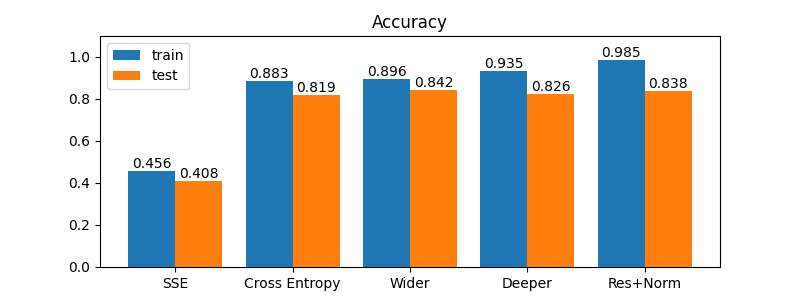

In [61]:
fig,ax = plt.subplots(figsize=(8,3))
h = ax.bar([-0.2,0.8,1.8,2.8,3.8],[accuracytrain,accuracy1train,accuracy3train,accuracy2train,accuracy4train],width=0.4,label='train')
ax.bar_label(h,fmt='%0.3f')
h = ax.bar([0.2,1.2,2.2,3.2,4.2],[accuracy,accuracy1,accuracy3,accuracy2,accuracy4],width=0.4,label='test')
ax.bar_label(h,fmt='%0.3f')
ax.set_xticks((0,1,2,3,4))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper','Res+Norm'])
ax.set_ylim([0,1])
ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()

In [62]:
# we want to randomize the dataset
class DatasetRandomized(torch.utils.data.Dataset):
    def __init__(self,dataset):
        self.dataset = dataset        
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        x,l = self.dataset[i]
        
        # randomize here
        # flips
        if torch.rand(1)>0.5:
            x = torch.flip(x,(-1,))
        if torch.rand(1)>0.5:
            x = torch.flip(x,(-2,))
        # transpose (note flips and transposes make rotations)
        if torch.rand(1)>0.5:
            x = torch.transpose(x,-1,-2)
            
        # gamma transform
        gamma = (torch.rand(1)-0.5)*2*0.5 + 1.0
        x = x**gamma
        
        # noise
        x = x + torch.randn_like(x)*0.01
        
        return x,l

In [63]:
dataset_randomized = DatasetRandomized(dataset)
dataloader_randomized = torch.utils.data.DataLoader(dataset_randomized,batch_size=8,num_workers=8)

In [64]:
model4r = Model4()
model4r = model4r.to(device)

In [65]:
optimizer = torch.optim.Adam(model4r.parameters(),lr=1e-3)

<IPython.core.display.Javascript object>


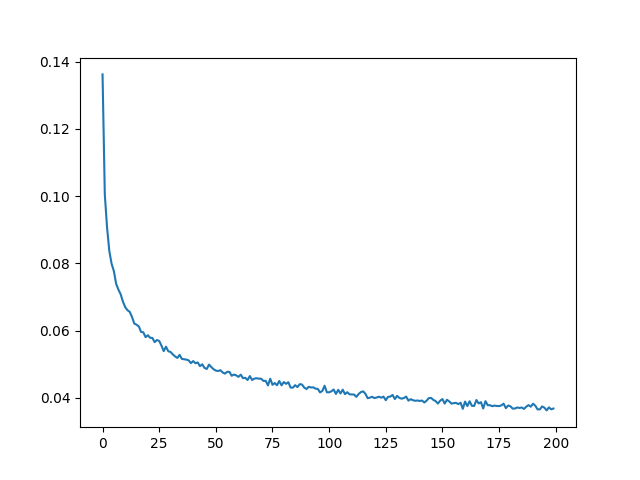

In [66]:
nepochs = 200
Esave = []
model4r = model4r.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
       
        
    Esum = 0.0
    for x,l in dataloader_randomized:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()        
        
        # forward
        out = model4r(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [67]:
# save the model to disk
#torch.save(model4r.state_dict(),'model4r.pt')

In [68]:
# load the model from disk
model4r.load_state_dict(torch.load('model4r.pt'))

<All keys matched successfully>

In [69]:


with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4r(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4rtrain = correct/count
print(f'accuracy train is {accuracy4rtrain}')

accuracy train is 0.9020821138891212


In [70]:





with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4r(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4rval = correct/count
print(f'accuracy val is {accuracy4rval}')

accuracy val is 0.8785046728971962


In [71]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model4r(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4r = correct/count
print(f'accuracy is {accuracy4r}')



accuracy is 0.8769365682548962


<IPython.core.display.Javascript object>


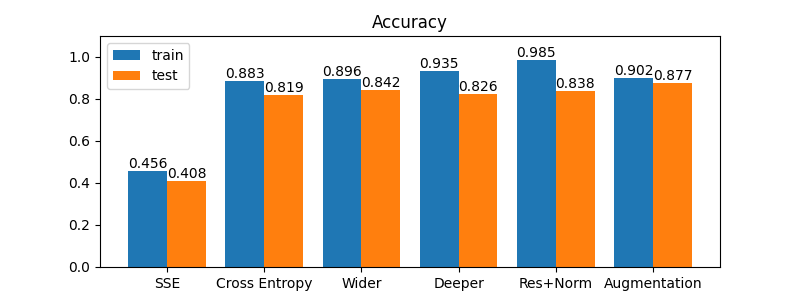

In [72]:
fig,ax = plt.subplots(figsize=(8,3))
h = ax.bar([-0.2,0.8,1.8,2.8,3.8,4.8],[accuracytrain,accuracy1train,accuracy3train,accuracy2train,accuracy4train,accuracy4rtrain],width=0.4,label='train')
ax.bar_label(h,fmt='%0.3f')
h = ax.bar([0.2,1.2,2.2,3.2,4.2,5.2],[accuracy,accuracy1,accuracy3,accuracy2,accuracy4,accuracy4r],width=0.4,label='test')
ax.bar_label(h,fmt='%0.3f')
ax.set_xticks((0,1,2,3,4,5))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper','Res+Norm','Augmentation'])
ax.set_ylim([0,1])

ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()

# Transfer learning

We will use a pretrained resnet 152 model.  See here for details of the model

https://arxiv.org/pdf/1512.03385.pdf

Note that this expects and input image of size 244x244.  It outputs 100 numbers to classify images into 1000 classes.


In [73]:
from torchvision.models import resnet152,ResNet152_Weights

In [74]:
r = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [75]:
print(r)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [76]:
# note the final layer is a linear layer, which maps from 2048 dimensions to 1000 dimensions.  
# We will have to replace this

In [77]:
dataset_big = BloodMNIST(split='train',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(244),
    torchvision.transforms.ToTensor()
])
)
dataset_big_randomized = DatasetRandomized(dataset_big)
dataloader_big = torch.utils.data.DataLoader(dataset_big_randomized,batch_size=8,num_workers=8)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [78]:
dataset_big_test = BloodMNIST(split='test',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(244),
    torchvision.transforms.ToTensor()
])
)
dataloader_big_test = torch.utils.data.DataLoader(dataset_big_test,batch_size=8,num_workers=8)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [79]:
dataset_big_val = BloodMNIST(split='val',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(244),
    torchvision.transforms.ToTensor()
])
)
dataloader_big_val = torch.utils.data.DataLoader(dataset_big_val,batch_size=8,num_workers=8)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [80]:
# we will "freeze" all the parameters here
for p in r.parameters():
    p.requires_grad = False

In [81]:
# replace the last layer with a map to 8 classes
r.fc = torch.nn.Linear(2048,8)

In [82]:
# double check we have frozen the parameters correctly

In [83]:
for name,p in r.named_parameters():
    print(name)
    print(p.requires_grad)

conv1.weight
False
bn1.weight
False
bn1.bias
False
layer1.0.conv1.weight
False
layer1.0.bn1.weight
False
layer1.0.bn1.bias
False
layer1.0.conv2.weight
False
layer1.0.bn2.weight
False
layer1.0.bn2.bias
False
layer1.0.conv3.weight
False
layer1.0.bn3.weight
False
layer1.0.bn3.bias
False
layer1.0.downsample.0.weight
False
layer1.0.downsample.1.weight
False
layer1.0.downsample.1.bias
False
layer1.1.conv1.weight
False
layer1.1.bn1.weight
False
layer1.1.bn1.bias
False
layer1.1.conv2.weight
False
layer1.1.bn2.weight
False
layer1.1.bn2.bias
False
layer1.1.conv3.weight
False
layer1.1.bn3.weight
False
layer1.1.bn3.bias
False
layer1.2.conv1.weight
False
layer1.2.bn1.weight
False
layer1.2.bn1.bias
False
layer1.2.conv2.weight
False
layer1.2.bn2.weight
False
layer1.2.bn2.bias
False
layer1.2.conv3.weight
False
layer1.2.bn3.weight
False
layer1.2.bn3.bias
False
layer2.0.conv1.weight
False
layer2.0.bn1.weight
False
layer2.0.bn1.bias
False
layer2.0.conv2.weight
False
layer2.0.bn2.weight
False
layer2.0.bn2

In [84]:
device = 'cuda:0'
r = r.to(device)

In [85]:
optimizer = torch.optim.Adam(r.parameters(),lr=1e-3)

<IPython.core.display.Javascript object>


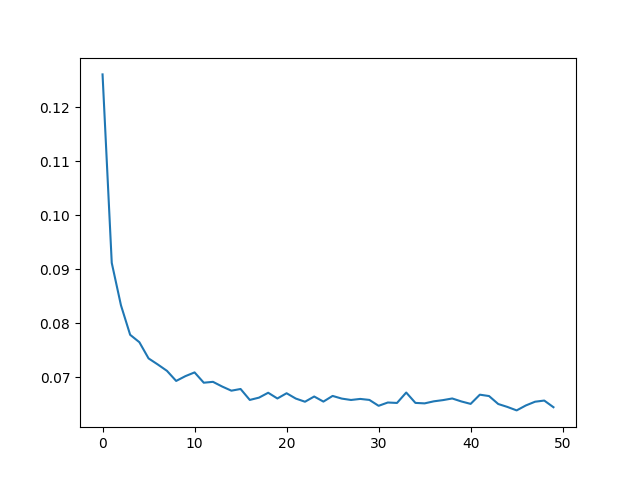

In [86]:
nepochs = 50
Esave = []
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):

    Esum = 0.0
    for x,l in dataloader_big:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()        
        
        # forward
        out = r(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    


In [87]:
# save the model to disk
#torch.save(r.state_dict(),'modelresnet.pt')

In [88]:
# load the model from disk
r.load_state_dict(torch.load('modelresnet.pt'))

<All keys matched successfully>

In [89]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_big:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = r(x)
        c = torch.argmax(out,-1) 
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyrestrain = correct/count
print(f'train accuracy is {accuracyrestrain}')



train accuracy is 0.8194665105778075


In [90]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_big_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = r(x)
        c = torch.argmax(out,-1)         
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyresval = correct/count
print(f'val accuracy is {accuracyresval}')

val accuracy is 0.8160046728971962


In [91]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_big_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = r(x)
        c = torch.argmax(out,-1) 
        
                
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyres = correct/count
print(f'accuracy is {accuracyres}')

accuracy is 0.7921660333235896


<IPython.core.display.Javascript object>


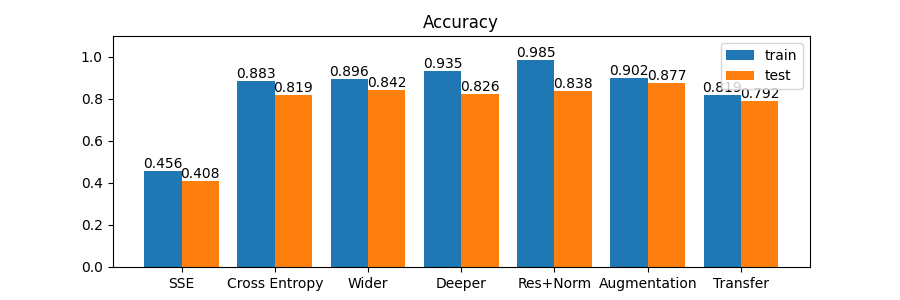

In [92]:
fig,ax = plt.subplots(figsize=(9,3))
h = ax.bar([-0.2,0.8,1.8,2.8,3.8,4.8,5.8],[accuracytrain,accuracy1train,accuracy3train,accuracy2train,accuracy4train,accuracy4rtrain,accuracyrestrain],width=0.4,label='train')
ax.bar_label(h,fmt='%0.3f')
h = ax.bar([0.2,1.2,2.2,3.2,4.2,5.2,6.2],[accuracy,accuracy1,accuracy3,accuracy2,accuracy4,accuracy4r,accuracyres],width=0.4,label='test')
ax.bar_label(h,fmt='%0.3f')
ax.set_xticks((0,1,2,3,4,5,6))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper','Res+Norm','Augmentation','Transfer'])
ax.set_ylim([0,1])

ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()

<IPython.core.display.Javascript object>


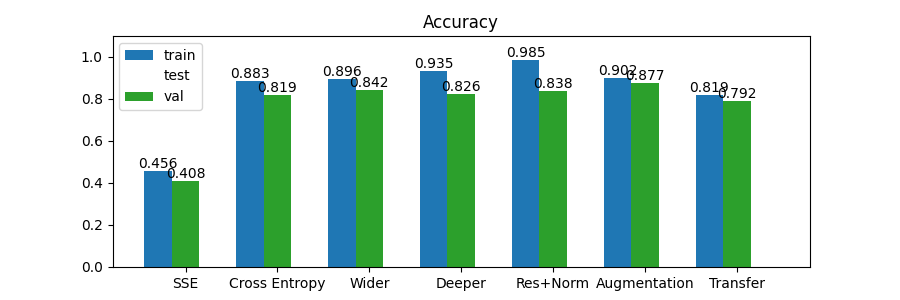

In [93]:
# now with val
import numpy as np
fig,ax = plt.subplots(figsize=(9,3))
h = ax.bar(np.arange(7)-0.3,[accuracytrain,accuracy1train,accuracy3train,accuracy2train,accuracy4train,accuracy4rtrain,accuracyrestrain],width=0.3,label='train')
ax.bar_label(h,fmt='%0.3f')
h = ax.bar(np.arange(7)+0.3,[accuracy,accuracy1,accuracy3,accuracy2,accuracy4,accuracy4r,accuracyres],width=0.3,label='test',visible=False)
ax.bar_label(h,fmt='%0.3f',visible=False)


h = ax.bar(np.arange(7)+0.0,[accuracy,accuracy1,accuracy3,accuracy2,accuracy4,accuracy4r,accuracyres],width=0.3,label='val')
ax.bar_label(h,fmt='%0.3f')


ax.set_xticks((0,1,2,3,4,5,6))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper','Res+Norm','Augmentation','Transfer'])
ax.set_ylim([0,1])

ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()

<IPython.core.display.Javascript object>


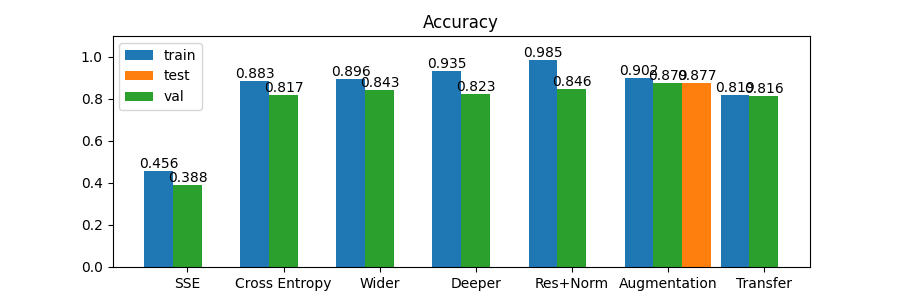

In [94]:
# now with val
fig,ax = plt.subplots(figsize=(9,3))
h = ax.bar(np.arange(7)-0.3,[accuracytrain,accuracy1train,accuracy3train,accuracy2train,accuracy4train,accuracy4rtrain,accuracyrestrain],width=0.3,label='train')
ax.bar_label(h,fmt='%0.3f')
#h = ax.bar(np.arange(7)+0.3,[accuracy,accuracy1,accuracy3,accuracy2,accuracy4,accuracy4r,accuracyres],width=0.3,label='test',visible=False)
#ax.bar_label(h,fmt='%0.3f',visible=False)
h = ax.bar(5+0.3,[accuracy4r],width=0.3,label='test',visible=True)
ax.bar_label(h,fmt='%0.3f',visible=True)

h = ax.bar(np.arange(7)+0.0,[accuracyval,accuracy1val,accuracy3val,accuracy2val,accuracy4val,accuracy4rval,accuracyresval],width=0.3,label='val')
ax.bar_label(h,fmt='%0.3f')


ax.set_xticks((0,1,2,3,4,5,6))
ax.set_xticklabels(['SSE','Cross Entropy','Wider','Deeper','Res+Norm','Augmentation','Transfer'])
ax.set_ylim([0,1])
#ax.text(0,0.38,'38%',horizontalalignment='center')
#ax.text(1,0.82,'82%',horizontalalignment='center')
ax.set_title('Accuracy')
ax.set_ylim(0,1.1)
ax.legend()